In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer,BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from collections import defaultdict

from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

import logging 
logging.basicConfig(level = logging.ERROR)



In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from datasets import load_dataset

dataset = load_dataset("onestop_english")


Generating train split:   0%|          | 0/567 [00:00<?, ? examples/s]

Dataset onestop_english downloaded and prepared to /root/.cache/huggingface/datasets/onestop_english/default/1.1.0/6b19eec5680862ad1cf1990e98b06a98d1fa4c85f3585dc4dfab93f52b89d9cf. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 567
    })
})

In [7]:
import pandas as pd

df = pd.DataFrame(dataset['train'])
df.columns = ['content', 'labels']


In [8]:
df

,content,labels
0,"When you see the word Amazon, what’s the first...",0
1,"To tourists, Amsterdam still seems very libera...",0
2,"Anitta, a music star from Brazil, has millions...",0
3,Google has made maps of the world’s highest mo...,0
4,The auction of a Banksy painting that disappea...,0
...,...,...
562,"In typical bad-boyfriend style, Dan Sullivan w...",2
563,Thousands of people protested on Australia’s b...,2
564,1 Race engineer \nA race engineer liaises betw...,2
565,More than one million British workers might be...,2


In [9]:
df.labels.value_counts()


0    189
1    189
2    189
Name: labels, dtype: int64

In [10]:
num_diff = df.labels.unique()
diff = ['beginner','intermediate','advanced']

label = dict(zip(num_diff, diff))

diff = list(diff)


In [11]:
df['Difficulty'] = df.labels.replace(label)
df.head()



,content,labels,Difficulty
0,"When you see the word Amazon, what’s the first...",0,beginner
1,"To tourists, Amsterdam still seems very libera...",0,beginner
2,"Anitta, a music star from Brazil, has millions...",0,beginner
3,Google has made maps of the world’s highest mo...,0,beginner
4,The auction of a Banksy painting that disappea...,0,beginner


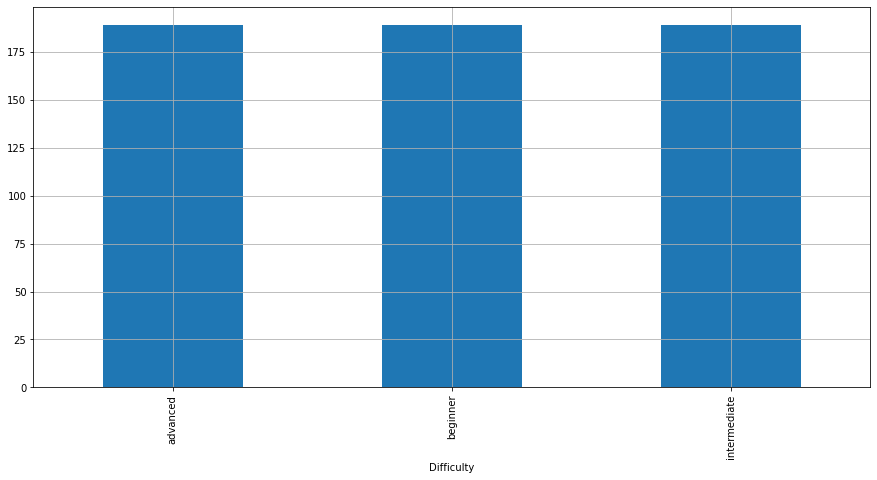

In [12]:
df.groupby('Difficulty')['content'].count().plot.bar(figsize=(15,7),grid=True)


In [13]:
df_beg=df[df['labels']==0]

In [14]:
df_int = df[df['labels']==1] 

In [15]:
df_int['content']=df_int['content'].apply(lambda x: x.replace('Intermediate \n', '').replace('Intermediate\n', ''))


In [16]:
df_int

,content,labels,Difficulty
189,"When you see the word Amazon, whats the first ...",1,intermediate
190,"To tourists, Amsterdam still seems very libera...",1,intermediate
191,"Brazils latest funk sensation, Anitta, has won...",1,intermediate
192,"It has mapped the worlds highest peaks, the oc...",1,intermediate
193,The controversial auction of a Banksy mural th...,1,intermediate
...,...,...,...
373,"In typical bad-boyfriend style, Dan Sullivan w...",1,intermediate
374,Thousands of people protested on Australias be...,1,intermediate
375,Race engineer A race engineer liaises between ...,1,intermediate
376,More than one million British workers might be...,1,intermediate


In [17]:
len(df_beg['content'].iloc[0].split())

421

In [18]:
df_adv = df[df['labels']==2] 

count the number of words

In [19]:
df_beg['content'].str.split().str.len().sum()

101048

In [20]:
df_int['content'].str.split().str.len().sum()

127934

In [21]:
df_adv['content'].str.split().str.len().sum()

155884

count the number of unique words

In [22]:
len(set(" ".join(df_beg['content']).split()))

16366

In [23]:
len(set(" ".join(df_int['content']).split()))

20249

In [24]:
len(set(" ".join(df_adv['content']).split()))

27065

Count Stopwords 

In [25]:
from wordcloud import STOPWORDS


In [26]:
df_beg['content'].iloc[0]

"When you see the word Amazon, what’s the first thing you think of – the world’s biggest forest, the longest river or the largest internet shop – and which do you think is most important? \nThese are the questions in a debate about the internet. Brazil and Peru have made objections to a bid made by the US online shop for the domain name, “.amazon”. \nAmazon has asked for its company name to be a top-level domain name (currently “.com”), but the South American governments say this would stop the use of this internet address for environmental protection, indigenous rights and other public interest uses. \nThere are many other disputed claims to names, including “.patagonia”. \nUntil now, the differences between commercial, governmental and other types of identity were easy to see in every internet address by the use of “.com”, “.gov” and 20 other categories. \nBut soon there are going to be more of these categories – or generic top-level domains (gTLDs) as they are technically known. \nT

In [27]:
df_int['content'].iloc[0]

'When you see the word Amazon, whats the first thing you think of  the worlds biggest forest, the longest river or the largest internet shop  and which do you think is most important?\nThese are questions in a debate about how to redraw the boundaries of the internet. Brazil and Peru have made objections to a bid made by the huge US e-commerce company for a prime new piece of cyberspace: .amazon.\nThe Seattle-based company has applied for its brand to be a top-level domain name (currently .com), but the South American governments argue this would prevent the use of this internet address for environmental protection, the promotion of indigenous rights and other public interest uses.\nTogether with many other disputed claims to names, including .patagonia, the issue goes directly to the heart of debates about the purpose and governance of the internet.\nUntil now, the differences between commercial, governmental and other types of identity were easy to see in every internet address by th

In [28]:
df_adv['content'].iloc[0]

'When you see the word Amazon, what’s the first thing that springs to mind – the world’s biggest forest, the longest river or the largest internet retailer – and which do you consider most important? \nThese questions have risen to the fore in an arcane, but hugely important, debate about how to redraw the boundaries of the internet. Brazil and Peru have lodged objections to a bid made by the US e-commerce giant for a prime new piece of cyberspace: “.amazon”. \nThe Seattle-based company has applied for its brand to be a top-level domain name (currently “.com”), but the South American governments argue this would prevent the use of this internet address for environmental protection, the promotion of indigenous rights and other public interest uses. \nAlong with dozens of other disputed claims to names, including “.patagonia” and “.shangrila ”, the issue cuts to the heart of debates about the purpose and governance of the internet. \nUntil now, the differences between commercial, governm

In [29]:
def count_stopwords(column):
    L=[]
    for x in column:
        L.append(len([w for w in str(x).lower().split() if w in STOPWORDS]))
    return sum(L)

In [30]:
count_stopwords(df_beg['content'])

43521

In [31]:
count_stopwords(df_int['content'])

56493

In [32]:
count_stopwords(df_adv['content'])

66518

WordCloud

In [33]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcloud(column):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(column))
    print(wordcloud)
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
    return wordcloud

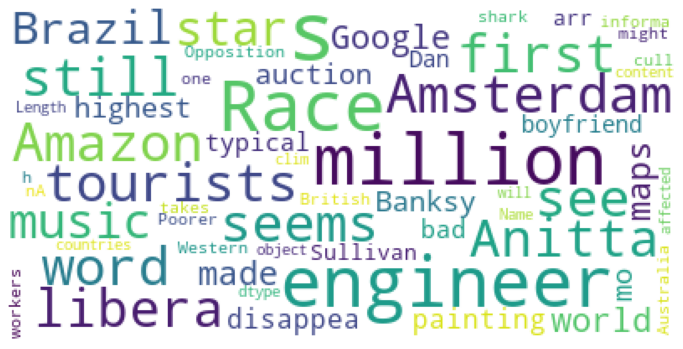

In [34]:
wordcloud(df_beg['content'])

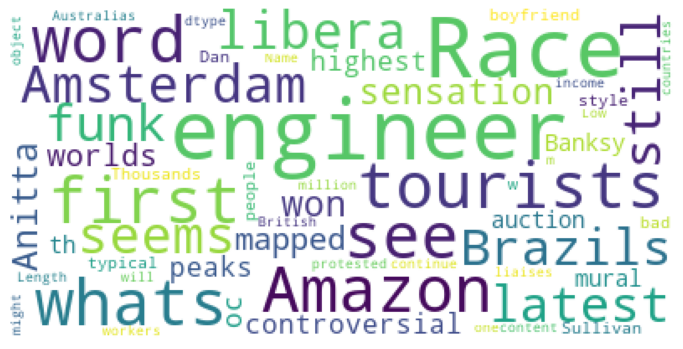

In [35]:
wordcloud(df_int['content'])

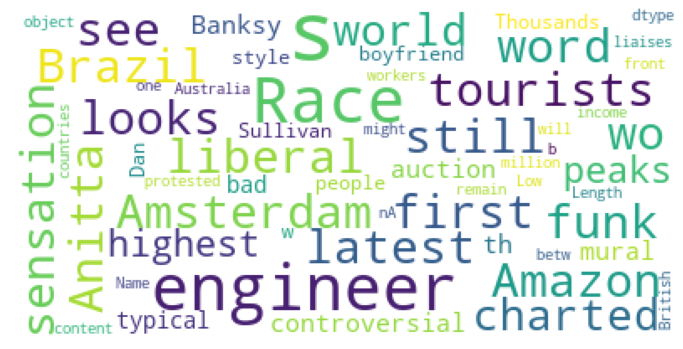

In [36]:
wordcloud(df_adv['content'])

Data Preprocessing

In [37]:
import re

In [38]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [39]:

def clean_text(text):
    #text=' '.join([contraction_mapping[i] if i in contraction_mapping.keys() else i for i in text.split()])
    text=re.sub("'s","",text)
    if text.split()[0] == 'Intermediate':
      text = ' '.join(text.split()[1:])
    text=' '.join([i for i in text.split() if i.isalpha()])
    text=re.sub('[^a-zA-Z]'," ",text)

    
    return text

In [40]:
df['content'] = df['content'].apply(clean_text)


In [41]:
df[df['Difficulty']=='intermediate']


,content,labels,Difficulty
189,When you see the word whats the first thing yo...,1,intermediate
190,To Amsterdam still seems very Recently the cit...,1,intermediate
191,Brazils latest funk has won millions of fans b...,1,intermediate
192,It has mapped the worlds highest the ocean the...,1,intermediate
193,The controversial auction of a Banksy mural th...,1,intermediate
...,...,...,...
373,In typical Dan Sullivan was late to breakfast ...,1,intermediate
374,Thousands of people protested on Australias be...,1,intermediate
375,Race engineer A race engineer liaises between ...,1,intermediate
376,More than one million British workers might be...,1,intermediate


In [42]:
from transformers import BertTokenizer,BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


In [43]:
class DiffDataset(Dataset):
    def __init__(self, contents, labels, tokenizer, max_len):
        self.contents = contents
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.contents)
  
    def __getitem__(self, item):
        content = str(self.contents[item])
        labels = self.labels[item]
        
        # Tokenizing the texts, while also including special tokens 
        # for start and end of the text, as well as padding
        encoding = self.tokenizer.encode_plus(
          content,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # We return here the data as Pytorch Tensor
        )

        return {
          'content': content,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(labels, dtype=torch.long)
        }


In [44]:
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42)

print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))



size of training set : 407
size of validation set : 46
size of test set : 114


In [45]:
def generate_dataloader(df, tokenizer, max_len, batch_size):
    ds = DiffDataset(
        contents=df.content.to_numpy(),
        labels=df.labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
      )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
      )


In [46]:
#model_name = 'bert-base-multilingual-uncased'
model_name = 'bert-base-uncased'

In [47]:
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [48]:
max_len = 256 
batch_size = 8

train_dataloader = generate_dataloader(df_train, tokenizer, max_len,batch_size)
val_dataloader = generate_dataloader(df_val, tokenizer, max_len,batch_size)
test_dataloader = generate_dataloader(df_test, tokenizer, max_len,batch_size)

data = next(iter(train_dataloader))



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [49]:
class DiffClassifier(nn.Module):

    def __init__(self, n_classes):
        super(DiffClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        # Adding drop out, keeping 90% of the last neurons of the raw BERT model
        #self.drop = nn.Dropout(p=0.1)
        # The last linear layer for multiclass classification
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    # Forward propagation function
    def forward(self, input_ids, attention_mask):
        model_outs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        last_hidden_state = model_outs[0]
        pooled_output = model_outs[1]
        return self.out(pooled_output)


In [50]:
len(diff)

3

In [51]:
model = DiffClassifier(len(diff))

# Running the classifier on GPU
model = model.to(device)


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([8, 256])
torch.Size([8, 256])


In [53]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  correct_bias=False)
epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0.1,
                                            num_training_steps=len(train_dataloader)*epochs)
loss_fn = nn.CrossEntropyLoss().to(device)


In [54]:
# Computing multiclass precision for the outputs of the model
def compute_precision(outputs, labels):
  op = outputs.cpu()
  la = labels.cpu()
  _, preds = torch.max(op, dim=1)
  # We choose 'weighted' averaging of the precision of each label because it takes into account the imbalance of labels in our tweets dataset
  # other viable averaging methods are 'micro'
  return torch.tensor(precision_score(la, preds, average='weighted',zero_division=0))

In [55]:
def train(model, train_dataloader,optimizer,scheduler):

        # Reset tracking variables at the beginning of each epoch
        precision, correct_predictions, batch_counts = 0, 0, 0
        losses = []

        # Put the model into the training mode
        model.train()

  
        # For each batch of training data...
        for d in train_dataloader:
              batch_counts +=1
              # Load batch to GPU
              input_ids = d["input_ids"].to(device)
              attention_mask = d["attention_mask"].to(device)
              labels = d["labels"].to(device)

              outputs = model(input_ids=input_ids,attention_mask=attention_mask)
              
              _, preds = torch.max(outputs, dim=1)
              
              # Compute loss and accumulate the loss values

              loss = loss_fn(outputs, labels)

              correct_predictions += torch.sum(preds == labels)
              losses.append(loss.item())
              precision +=  compute_precision(outputs, labels)
            
              loss.backward()

              # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
              # Update parameters and the learning rate  
              optimizer.step()
              scheduler.step()
              optimizer.zero_grad()
          # Accuracy, loss, precision
        return correct_predictions.double() / len(df_train), np.mean(losses), precision/batch_counts

In [56]:
def eval(model, valid_dataloader, loss_fn, device, n):
    model = model.eval()


    correct_predictions , precision ,batch_counts = 0,0,0
    losses = []

    with torch.no_grad():
        for d in valid_dataloader:
            batch_counts += 1

            # Preparing inputs
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Running inference using the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, labels)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == labels)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 
            precision += compute_precision(outputs,labels)

            losses.append(loss.item())
    # Accuracy, loss, precision 
    return correct_predictions.double()/n, np.mean(losses), precision/batch_counts 

In [57]:
history = defaultdict(list)
b_accuracy = 0

for epoch in range(epochs):
  
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 20)

  train_acc, train_loss, train_preci = train(
        model,
        train_dataloader,    
        optimizer, 
        scheduler,
      )
  print(f"Train : Loss {train_loss}, Accuracy : {train_acc*100:.2f} %, Precision : {train_preci}")

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_precision'].append(train_preci)

  val_acc, val_loss, val_preci = eval(
        model,
        val_dataloader,
        loss_fn, 
        device,
        len(df_val),
      )

  print(f'Val : Loss :{val_loss}, Accuracy : {val_acc*100:.2f} %, Precision : {val_preci}')  
  print()

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_precision'].append(val_preci)
  
  if val_acc > b_accuracy:
    torch.save(model.state_dict(), 'bert_model_baseline.bin')
    b_accuracy = val_acc

Epoch 1/5
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train : Loss 1.105401285723144, Accuracy : 32.19 %, Precision : 0.15637254901960784


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val : Loss :0.9944775601228079, Accuracy : 45.65 %, Precision : 0.3517857142857143

Epoch 2/5
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train : Loss 0.777381887622908, Accuracy : 59.21 %, Precision : 0.6193335667600374


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val : Loss :0.6744328563412031, Accuracy : 78.26 %, Precision : 0.8599537037037036

Epoch 3/5
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train : Loss 0.5826610050657216, Accuracy : 74.20 %, Precision : 0.7773109243697478


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val : Loss :0.7589143713315328, Accuracy : 73.91 %, Precision : 0.8513888888888889

Epoch 4/5
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train : Loss 0.3306514213007747, Accuracy : 86.49 %, Precision : 0.8726307189542483


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val : Loss :0.4947383652130763, Accuracy : 82.61 %, Precision : 0.8807870370370369

Epoch 5/5
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train : Loss 0.11421172180231295, Accuracy : 96.07 %, Precision : 0.9725898692810457


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val : Loss :0.5394690906008085, Accuracy : 80.43 %, Precision : 0.8807870370370369



In [58]:
history['train_acc']

[tensor(0.3219, device='cuda:0', dtype=torch.float64),
 tensor(0.5921, device='cuda:0', dtype=torch.float64),
 tensor(0.7420, device='cuda:0', dtype=torch.float64),
 tensor(0.8649, device='cuda:0', dtype=torch.float64),
 tensor(0.9607, device='cuda:0', dtype=torch.float64)]

In [60]:
history['val_acc']

[tensor(0.4565, device='cuda:0', dtype=torch.float64),
 tensor(0.7826, device='cuda:0', dtype=torch.float64),
 tensor(0.7391, device='cuda:0', dtype=torch.float64),
 tensor(0.8261, device='cuda:0', dtype=torch.float64),
 tensor(0.8043, device='cuda:0', dtype=torch.float64)]

In [62]:
def testing(model, dataloader):
  model = model.eval()
  
  contents = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in dataloader:

      texts = d["content"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      contents.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(labels)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return contents, predictions, prediction_probs, real_values

In [63]:
y_contents, y_pred, y_pred_probs, y_test = testing(
  model,
  test_dataloader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [64]:
print(classification_report(y_test, y_pred, target_names=diff))

              precision    recall  f1-score   support

    beginner       0.88      0.84      0.86        43
intermediate       0.64      0.84      0.73        38
    advanced       0.91      0.64      0.75        33

    accuracy                           0.78       114
   macro avg       0.81      0.77      0.78       114
weighted avg       0.81      0.78      0.78       114



In [65]:
y_pred_probs

tensor([[2.1913e-03, 8.9164e-01, 1.0617e-01],
        [5.7084e-04, 1.4659e-02, 9.8477e-01],
        [4.7896e-01, 5.1742e-01, 3.6242e-03],
        [4.7957e-04, 2.2747e-02, 9.7677e-01],
        [5.3533e-04, 1.3503e-02, 9.8596e-01],
        [2.6136e-03, 9.4689e-01, 5.0498e-02],
        [4.9829e-01, 4.9910e-01, 2.6101e-03],
        [5.2920e-04, 6.2830e-03, 9.9319e-01],
        [4.6252e-04, 6.9456e-03, 9.9259e-01],
        [9.8168e-01, 1.7574e-02, 7.4864e-04],
        [9.9462e-01, 4.7638e-03, 6.1185e-04],
        [9.3758e-01, 6.1455e-02, 9.6995e-04],
        [4.7283e-04, 1.2365e-02, 9.8716e-01],
        [5.4815e-03, 9.8171e-01, 1.2804e-02],
        [1.7673e-03, 3.9192e-01, 6.0631e-01],
        [9.7100e-01, 2.8196e-02, 8.0563e-04],
        [6.7348e-02, 9.2912e-01, 3.5357e-03],
        [2.4336e-03, 9.0508e-01, 9.2491e-02],
        [6.1904e-04, 2.1602e-02, 9.7778e-01],
        [8.3404e-01, 1.6412e-01, 1.8341e-03],
        [9.9547e-01, 3.8095e-03, 7.1725e-04],
        [9.8793e-01, 1.1413e-02, 6

In [66]:
out_df = pd.DataFrame()
out_df['content'] = y_contents
out_df['true_label'] = y_test
out_df['pred_label'] = y_pred

In [67]:
out_df

,content,true_label,pred_label
0,What is it like to look at the very last of To...,2,1
1,SeaWorld has suffered an collapse in profits a...,2,2
2,On the market square in Rjukan stands a statue...,1,1
3,The world shares him and London claims him but...,2,2
4,The regulation eight hours in the office is Th...,2,2
...,...,...,...
109,Some cities have Lima has black They fly in gr...,0,0
110,David Cameron has declared a in the Scottish i...,2,2
111,Clay Cockrell is sitting in his of ce across t...,1,1
112,Police and intelligence agencies around the wo...,0,0


In [68]:
out_df.to_csv('out_MBERT_uncased_256.csv')